In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

### Transactions data 
##### pps dataframe with 'pps', 'count' for each month (End of month date) 

In [2]:
# Read in the data from 'transactions.csv'

df = pd.read_csv('data/transactions.csv')
df.drop(['id'], axis=1, inplace=True)

In [3]:
# Clean up the df DataFrame
df['pps'] = df['prix'] / df['surface_habitable']
df.insert(3, 'pps', df.pop('pps'))
df['date_transaction'] = pd.to_datetime(df.date_transaction)

df = df.set_index(pd.DatetimeIndex(df['date_transaction']))

In [4]:
#Drop column where surface_habitable is 0; this way we ommit having infinity as pps (by dividing by 0)
df.drop(df.loc[
    (df['surface_habitable'] == 0) |
    (df['prix'] == 0)
].index, axis=0, inplace=True)

##Query the df dataframe (original transactions.csv) to filter the cases by house price or type
#df1 = df.loc[
#    (df['departement'] == 75)
#].copy()


# Group by the dates with the Grouper function
pps = df.groupby(pd.Grouper(freq="ME"))['pps'].agg(['mean', 'count'])


# Create new column with the monthly differences of the mean pps prices 
#pps['pps_diff'] = pps.diff(axis=0)['mean']
pps['pps_diff'] = pps['mean'].pct_change() * 100
pps['count_diff'] = pps['count'].pct_change() * 100


#Rename columns
pps.rename(columns={'mean': 'pps'}, inplace=True)

In [5]:
pps.head()

,pps,count,pps_diff,count_diff
date_transaction,,,,
2014-01-31,2693.001927,17231,NaN,NaN
2014-02-28,2729.413736,12036,1.352090,-30.149150
2014-03-31,2761.948957,14440,1.192022,19.973413
2014-04-30,2658.822842,19168,-3.733817,32.742382
2014-05-31,2665.053894,18530,0.234354,-3.328464


### Gouv Data
##### 

In [6]:
# Read in the data
n_sales = pd.read_csv('data/nombre-vente-immobilier-dc.csv', encoding ="ISO-8859-1", delimiter=";")

# Transform the data
# Drop column that are filled with only N/A values
n_sales.drop(columns=[key for key, value in n_sales.isna().all().to_dict().items() if value==True]+["Mois de l'acte de vente"], inplace=True)

n_sales = n_sales.set_index('DEP')
n_sales = n_sales.T

n_sales['month'] = n_sales.apply(lambda row: row.name.split('-')[0], axis=1)
n_sales['year'] = n_sales.apply(lambda row: int("20" + row.name.split('-')[1]), axis=1)

In [7]:
# Make the data column in the same way as the other dataframes

from calendar import month_abbr
from pandas.tseries.offsets import MonthEnd

months = [m.lower() for m in month_abbr]
new_m = ['mrt', 'mei', 'okt']
m_pos = [3, 5, 10]

for x,y in zip(m_pos, new_m):
    months[x] = y

# Combine the Month and Year columns into a Date column that will be used as the index
n_sales['month'] = n_sales['month'].map(lambda m: '%0*d' % (2, months.index(m)))
n_sales['date'] = n_sales.apply(lambda row: str(row['year']) + str(row['month']), axis=1) 


n_sales['date'] = pd.to_datetime(n_sales.date, format="%Y%m") + MonthEnd(1)
n_sales = n_sales.set_index(pd.DatetimeIndex(n_sales['date']))
n_sales.drop(columns=['month', 'year', 'date'], inplace=True)

# Remove the "%" sign from all the inputs in the dataframe
n_sales = n_sales.apply(np.vectorize(lambda i: i.split("%")[0] if isinstance(i, str) else i))

# Transform all the data to floats (Not int because there are some nan values)
n_sales = n_sales.astype(float)

In [8]:
n_sales.head()

DEP,01,02,03,04,05,06,07,08,09,10,...,91,92,93,94,95,971,972,973,974,00
date,,,,,,,,,,,,,,,,,,,,,
2005-04-30,-1.0,3.0,1.0,-4.0,-5.0,-4.0,1.0,0.0,-1.0,0.0,...,-4.0,3.0,-1.0,2.0,0.0,-1.0,8.0,11.0,1.0,0.0
2005-05-31,-2.0,3.0,2.0,-7.0,-8.0,-6.0,1.0,-1.0,1.0,-2.0,...,-6.0,1.0,-1.0,1.0,0.0,1.0,1.0,10.0,-2.0,-1.0
2005-06-30,-4.0,2.0,0.0,-7.0,-6.0,-5.0,0.0,-1.0,-4.0,0.0,...,-6.0,-1.0,-4.0,-2.0,-1.0,2.0,-1.0,9.0,-2.0,-1.0
2005-07-31,-3.0,2.0,4.0,-6.0,-6.0,-4.0,0.0,1.0,-3.0,2.0,...,-6.0,0.0,-4.0,-1.0,-1.0,6.0,1.0,8.0,1.0,-1.0
2005-08-31,-3.0,3.0,2.0,-5.0,-6.0,-3.0,-2.0,1.0,-5.0,1.0,...,-5.0,0.0,-3.0,0.0,-2.0,6.0,8.0,26.0,0.0,0.0


### interest data
##### interest dataframe with 'taux' and 'diff' columns

In [9]:
#Read in the 'taux_interet.csv' file
interest = pd.read_csv('data/taux_interet.csv')

#Clean up the DataFrame
interest['date'] = pd.to_datetime(interest['date'])
interest = interest.set_index(pd.DatetimeIndex(interest['date']))
interest = interest.drop(columns=['date'])
interest = interest.rename(columns={'taux': 'interest'})

#Reverse the order of the dataframe before calculating the 'diff' column
interest = interest.iloc[::-1]

#interest['interest_diff'] = interest.diff(axis=0)['taux']
interest['interest_diff'] = interest['interest'].pct_change() * 100
interest['interest_pct_pt'] = interest.apply(lambda row: row['interest'] - (row['interest'] * (1 - (row['interest_diff'] / 100))), axis=1)

In [10]:
interest.head()

,interest,interest_diff,interest_pct_pt
date,,,
2014-12-31,2.55,NaN,NaN
2015-01-31,2.49,-2.352941,-0.058588
2015-02-28,2.42,-2.811245,-0.068032
2015-03-31,2.34,-3.305785,-0.077355
2015-04-30,2.24,-4.273504,-0.095726


### Histogram Dataframe

In [11]:
hist_df = df.loc['2015-01-01':].copy()

In [12]:
# Creating the 'interest_full' DataFrame: an interest value per day
from datetime import date, timedelta

sdate = date(2015,1,1)   # start date
edate = date(2023,10,31)   # end date

interest_full = pd.DataFrame(data=pd.date_range(sdate,edate-timedelta(days=1),freq='d'),columns=['date'])
interest_full = interest_full.set_index(pd.DatetimeIndex(interest_full['date']))

interest_full['interest'] = interest_full.apply(lambda row: interest.iloc[interest.index.get_indexer([row.name], method="nearest")[0]]['interest'], axis=1)
interest_full.drop(columns=['date'], inplace=True)

In [13]:
hist_df = hist_df.join(interest_full, how='outer')

In [14]:
hist_df = hist_df[['id_transaction', 'ville', 'departement', 'prix', 'pps', 'type_batiment', 'interest']].dropna(axis=0)

In [15]:
# Delete 'interest_full' from memory
del interest_full

In [16]:
def histplot(i:int):
    temp = hist_df.loc[
        (hist_df['interest'] <= i+.5) &
        (hist_df['interest'] >= i) 
    ].copy()
    days = len(temp.index.unique().to_list())

    counts, bins = np.histogram(temp['prix'], bins=range(0, 750000, 25000))
    bins = 0.5 * (bins[:-1] + bins[1:])

    return counts, bins, days

In [17]:
def analyze_histograph(iter):
    
    # Initialize the dataframe
    result = pd.DataFrame(data={str(r):0 for r in range(1, 8)}, index=['remove'])
    groups=range(0, 900000, 100000)
    days_dict = dict()

    rename_dict = {
    "1": "0-100.000€",
    "2": "100.000-200.000€",
    "3": "200.000-300.000€",
    "4": "300.000-400.000€",
    "5": "400.000-500.000€",
    "6": "500.000-600.000€",
    "7": "600.000-700.000€",
    "8": "700.000-800.000€"
    }

    # Iterate over the input of this function: list of interest percentages we want to check (f.e: [0.0, 0.5, 1.0, 1.5])
    for it in iter:
        try:
            counts, bins, days = histplot(it)
            days_dict.update({it:days})
            # Transform to python list
            counts = [c for c in counts]

            rslt = dict(zip(bins, counts))
            t = dict()

            for k,v in rslt.items():
                for i in range(len(groups) - 1):
                    if groups[i] <= k <= groups[i+1]:
                        if str(i+1) in t.keys():
                            t[str(i+1)] += v
                        else:
                            t.update({str(i+1): v})
                    if i == range(len(groups) - 1)[-1]:
                        t.update({str(i+1):0})
            result = pd.concat([result, pd.DataFrame(data=t, index=[f'{it}%-{it+0.5}%'])])

        except:
            days_dict.update({it:0})
            result = pd.concat([result, pd.DataFrame(data={str(k+1):0 for k in range(len(groups) - 1)}, index=[f'{it}%-{it+0.5}%'])])
    
    result = result.drop(['remove'])
    result = result.rename(columns=rename_dict)
    return result, days_dict

### Final dataframe
##### Combining the 2 dataframes to get information of interest and price changes per month

In [18]:
##Create lists of all the indexes of the 2 dataframes
#pps_list = pps.index.to_list()
#interest_list = interest.index.to_list()
#common = list(set(pps_list) & set(interest_list))

# Concat the 2 dataframes based on the index (dates)
final = pd.concat([pps, interest], axis=1, join="inner")

# Drop NA
final = final.dropna()

### Plotting

In [19]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = n_sales.index, y = n_sales['00'], name='Montly dwelling sales changes', line_shape='spline', line_smoothing=0.7),
    secondary_y=False)

fig.add_trace(
    go.Scatter(x = interest.index, y = interest['interest_diff'], name='Interest monthly change', line_shape='spline', line_smoothing=0.7),
    secondary_y=True)


fig.update_layout(dict(title="Monthly change in dwelling sales vs change in interest since 2015, in France",
                        title_font_family="Times New Roman",
                        title_font_size = 24,
                        xaxis_range=['2015-01-01','2024-01-31'],
                        yaxis1 = dict(
                            range=[-40,40], # update
                            tickmode = 'array',
                            tickvals = [i for i in range(-40,40,10)],
                            ticksuffix =" ",
                        ),
                        yaxis2 = dict(
                            range=[-10,10], # update
                            tickmode = 'array',
                            tickvals = [i for i in range(-10,10,5)],
                        ), 
                        xaxis = dict(
                            tickangle = 45
                        )
                       ))
fig.show()

<AxesSubplot: >

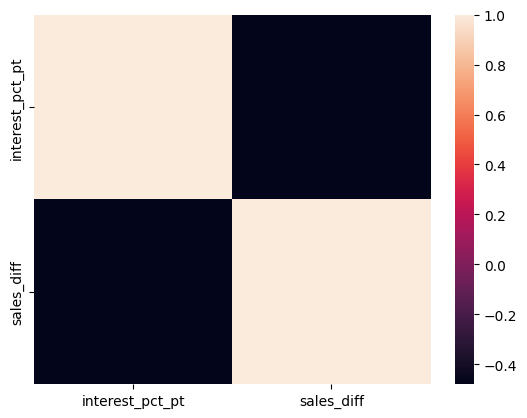

In [20]:
sns.heatmap(
    (pd.concat([interest['interest_pct_pt'], n_sales['00']], axis=1, join="inner")
     .rename(columns={'00':'sales_diff'})
     .dropna()
     .corr())
    )

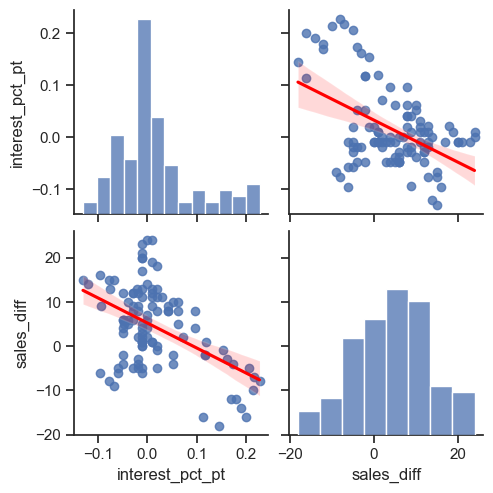

In [21]:
sns.set_theme(style="ticks", color_codes=True)
sns.pairplot(
    pd.concat([interest['interest_pct_pt'], n_sales['00']], axis=1, join="inner").rename(columns={'00': 'sales_diff'}).dropna(),
     kind='reg',
     plot_kws={'line_kws':{'color':'red'}}
    )

In [22]:
fig2 = px.scatter(
    data_frame=final, 
    x=final['interest_diff'], 
    y=n_sales.loc["2015-01-31":"2023-06-30"]['00'],
    #trendline="ols",
    #trendline_options=dict(frac=0.1)
    hover_name=final.index.date,
    color=final.index.year,
    #facet_col=final.index.year,
    labels={
        "interest_diff": "Change in Interest (Monthly)",
        "y": "Change in average house price (Monthly)",
        "color": "Year"
        }
    )

fig2.add_shape(type="rect",
    x0=0, y0=-15, x1=10, y1=0,
    fillcolor="red",
    opacity=0.1,
)

fig2.add_shape(type="rect",
    x0=-8, y0=0, x1=0, y1=30,
    fillcolor="red",
    opacity=0.1,
)

fig2.update_layout(
    yaxis_range=[-15,30], 
    xaxis_range=[-8, 10]
)
fig2.update_layout(dict(title="Interest changes vs. house price changes in France since 2015",
                        title_font_family="Times New Roman",
                        title_font_size = 24,
                       ))

fig2.show()

In [ ]:
##### Here we see that in 2022-2023 the positive interest changes have matched a drop in house prices, something we haven't seen in a while
### Also note that we had the highest interest and also the steepest ascend in interest we have seen in a long time 

In [23]:
fig3_df = n_sales.loc[
        n_sales.index.isin(final.loc['2020-01-01':'2023-06-30'].index.to_list())
    ].copy()

fig3 = px.scatter(
    data_frame=final, 
    x=final.loc['2020-01-01':'2023-06-30']['interest_diff'], 
    y=fig3_df['00'], 
    hover_name=fig3_df.index.date,
    color=fig3_df.index.month,
    facet_col=fig3_df.index.year,
    facet_col_wrap=2,
    labels={
        "x": "Change in Interest (Monthly)",
        "y": "Price changes",
        "color": "Year"
        },
    title="Interest changes vs. house price changes in France since 2015"
    )

fig3.update_layout(dict(title="Interest changes vs. house price changes in France since 2015",
                        title_font_family="Times New Roman",
                        title_font_size = 24,
                       ))

fig3.show()

In [ ]:
### Late 2020 and early 2021 we see a decrease of prices and interest changes --> we can assign these changes to the COVID crisis
# Historicly, when we see a decrease in both prices and interest rates, we are in a crisis (i.e: 2008 Banking crisis)

### For 2022: the interest changes are constantly positive (the interest keeps going up):
# In the beginning the prices are still increasing (because we just had interest decreases at the end of last year,
# But after a couple month we see the prices start dipping

### In 2023: the interest increases keep occuring monthly: prices are now beginning to decrease monthly

# -> Looks like we have a latency of a couple months before we see price changes have an obvious effect on house prices.


In [24]:
# Call the 'plot_analyzer' to return a dataframe
frame_full, days_dict = analyze_histograph([r/10 for r in range(0, 40, 5)])
frame = frame_full.copy()
# Fix and clean the dataframe
frame['sum'] = frame.sum(axis=1)    
frame = frame.iloc[:,:-1].div(frame['sum'], axis=0)
frame = frame.dropna(axis=0)

In [25]:
# Divide the sums of each row by the total number of days to get the normalized result

frame_full = frame_full.sum(axis=1)
#frame_full = frame_full.where(frame_full > 0).dropna(axis=0)
frame_full = frame_full.to_frame().rename(columns={0: 'count'})

# Add the days as a new column (this represents the amount of days the interest was between these 2 values in total)
frame_full['days'] = list(days_dict.values())
frame_full['norm'] = frame_full['count']/frame_full['days']

frame_full.drop(columns=['days'], inplace=True)
frame_full.dropna(axis=0, inplace=True)

In [26]:
fig4 = px.bar(x=frame_full.index, y=frame_full['norm'])
fig4.update_layout(
    title="Total sales volumes of dwellings vs Interest rate ranges in France (2015-2024)",
    title_font_family = "Times New Roman",
    title_font_size = 24,
    xaxis_title="Interest rate ranges", 
    yaxis_title="Sales volumes"
)

fig4.show()

In [27]:
fig5 = make_subplots(specs=[[{"secondary_y": True}]])

fig5.add_trace(go.Scatter(
    x=frame.iloc[0].index,
    y=frame.iloc[0].values,
    name=frame.iloc[0].name,
    marker=dict(
        color='rgb(34,163,192)'
    )))

fig5.add_trace(go.Scatter(
    x=frame.iloc[-1].index,
    y=frame.iloc[-1].values,
    name=frame.iloc[-1].name,
    yaxis='y2'
    ),secondary_y=False)

fig5.update_layout(dict(title="Price distribution for high vs. low Interest Rates in France (2015-2024)",
                        title_font_family="Times New Roman",
                        title_font_size = 24,
                        yaxis=dict(tickformat=".0%")
                       ))
fig5.show()